# ECE 232E Project 1 - Random Graphs and Random Walks
By Anthony Lei, Swetha Pillai, and Morgan Worthington

In [2]:
install.packages("igraph")
install.packages("pracma")

library('igraph')
library('Matrix')
library('pracma')

install.packages('matrixStats')
library(matrixStats)


The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages

The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages



Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'pracma'


The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu





The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages


# 1. Generating Random Networks

first third - Anthony

second third - Swetha

## 3. Create a modified preferential attachment model that penalizes the age of a node

(a) Produce such an undirected network with 1000 nodes and parameters m = 1,
α = 1, β = −1, and a = c = d = 1, b = 0. Plot the degree distribution. What is the
power law exponent?

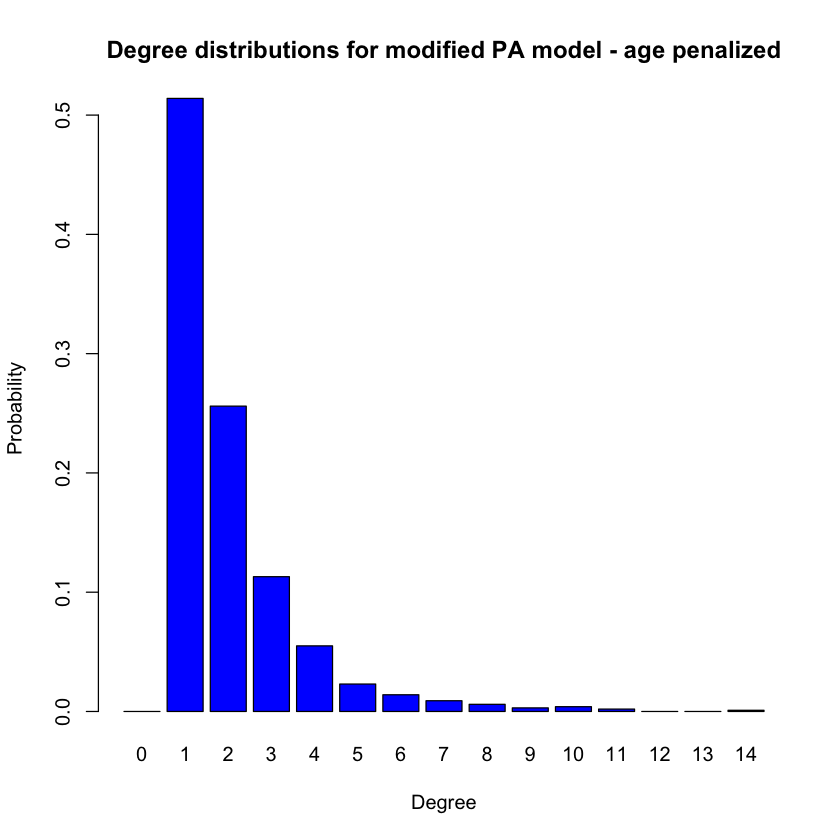

In [3]:
pa_age <- sample_pa_age(1000, m=1, pa.exp=1, aging.exp=-1, zero.deg.appeal=1, zero.age.appeal=0, deg.coef=1, age.coef=1, directed=FALSE)

# Plotting the node degree distribution as a bar plot
node_deg_dist = degree.distribution(pa_age)
xVals = c(0: (length(node_deg_dist) - 1))
barplot(node_deg_dist, names.arg=xVals, xlab="Degree", ylab="Probability",
        main = paste("Degree distributions for modified PA model - age penalized", sep = " "),col="blue")


Call:
lm(formula = log10(probability) ~ log10(degree))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33734 -0.13183  0.04749  0.08599  0.20948 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.0483     0.1238    0.39    0.705    
log10(degree)  -2.5204     0.1554  -16.22 1.65e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1729 on 10 degrees of freedom
Multiple R-squared:  0.9634,	Adjusted R-squared:  0.9597 
F-statistic:   263 on 1 and 10 DF,  p-value: 1.648e-08


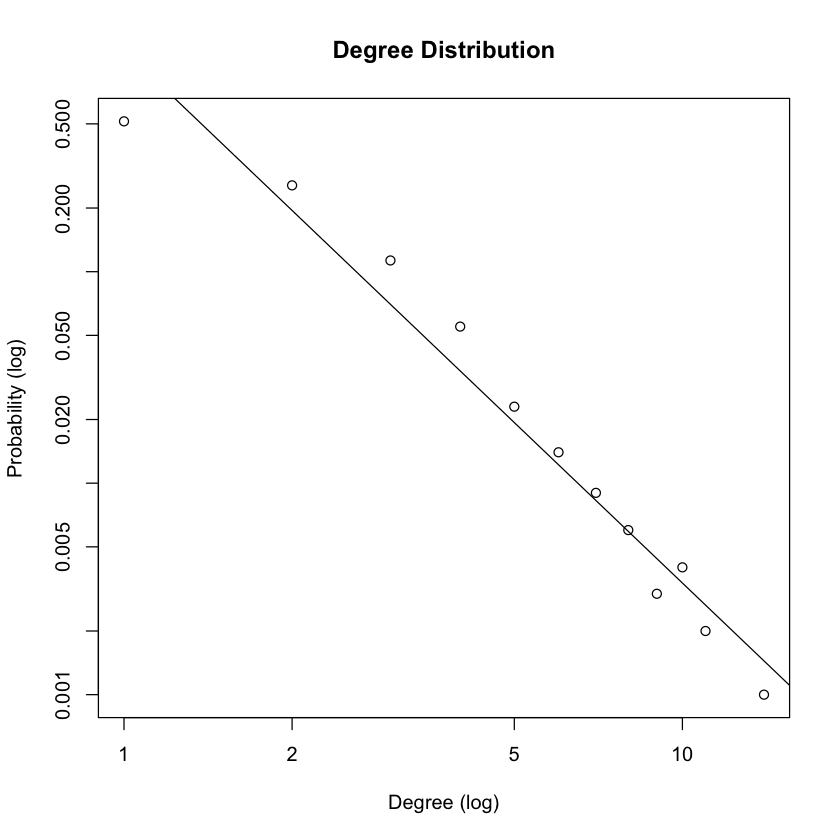

In [4]:
plot_degree_distribution = function(graph) {
  # calculate degree
  d = degree(graph, mode = "all")
  dd = degree.distribution(graph, mode = "all", cumulative = FALSE)
  degree = 1:max(d)
  probability = dd[-1]
  # delete blank values
  nonzero.position = which(probability != 0)
  probability = probability[nonzero.position]
  degree = degree[nonzero.position]
  # plot
  plot(probability ~ degree, log = "xy", xlab = "Degree (log)", ylab = "Probability (log)", 
       col = 1, main = "Degree Distribution")
  abline(lm(log10(probability) ~ log10(degree)))
  summary(lm(log10(probability) ~ log10(degree)))
}

plot_degree_distribution(pa_age)

From the lectures, the power-law exponent corresponds to the slope of the linear regression on the log-log plot. Here, it is approximately -2.5.

(b) Use fast greedy method to find the community structure. What is the modularity?

In [5]:
modularity(cluster_fast_greedy(pa_age))

[1] 0.9358698

# 2. Random Walk on Networks

### 1. Random walk on Erdos-Renyi networks

(a) Create an undirected random network with 1000 nodes, and the probability p for drawing an edge between any pair of nodes equal to 0.01.

In [9]:
num_nodes = 1000
edge_prob = 0.01
g_1000 = sample_gnp(num_nodes, edge_prob, directed = FALSE)

(b) Let a random walker start from a randomly selected node (no teleportation). We use t to denote the number of steps that the walker has taken. Measure the average distance (defined as the shortest path length) ⟨s(t)⟩ of the walker from his starting point at step t. Also, measure the variance $σ^2(t) = ⟨(s(t) − ⟨s(t)⟩)^2⟩$ of this distance. Plot ⟨s(t)⟩ v.s. t and $σ^2(t)$ v.s. t. Here, the average ⟨·⟩ is over random choices of the starting nodes.

In [7]:
t = 100
ver_sequence = c(1:t)

# Helper function provided for random walk
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}


random_walk = function (g, num_steps, start_node, transition_matrix = NULL){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    for(i in 1:num_steps){
    
        # fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        ver_sequence[i] = v
        PMF = transition_matrix[v, ]
        # perform random walk
        v = sample(1:vcount(g), 1, prob = PMF)
        if(i == t)
          # dis = distances(g,v= start_node, to=v)
          # dis = shortest.paths(g,)
          degree_ = degree(g,v)
    }
   return(list(distances = ver_sequence,degrees = degree_))
}

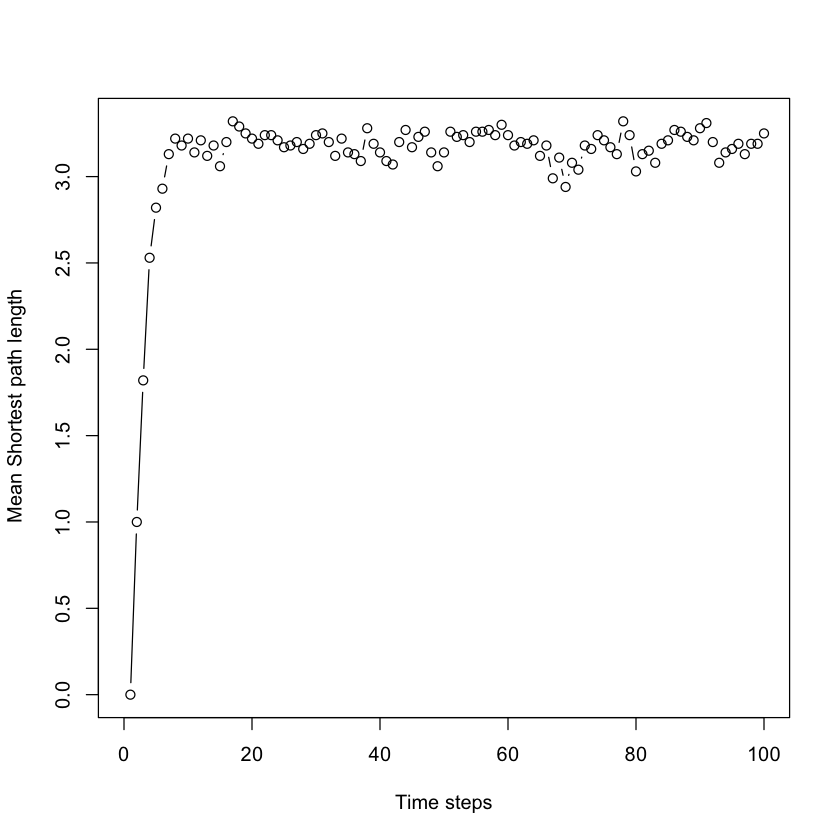

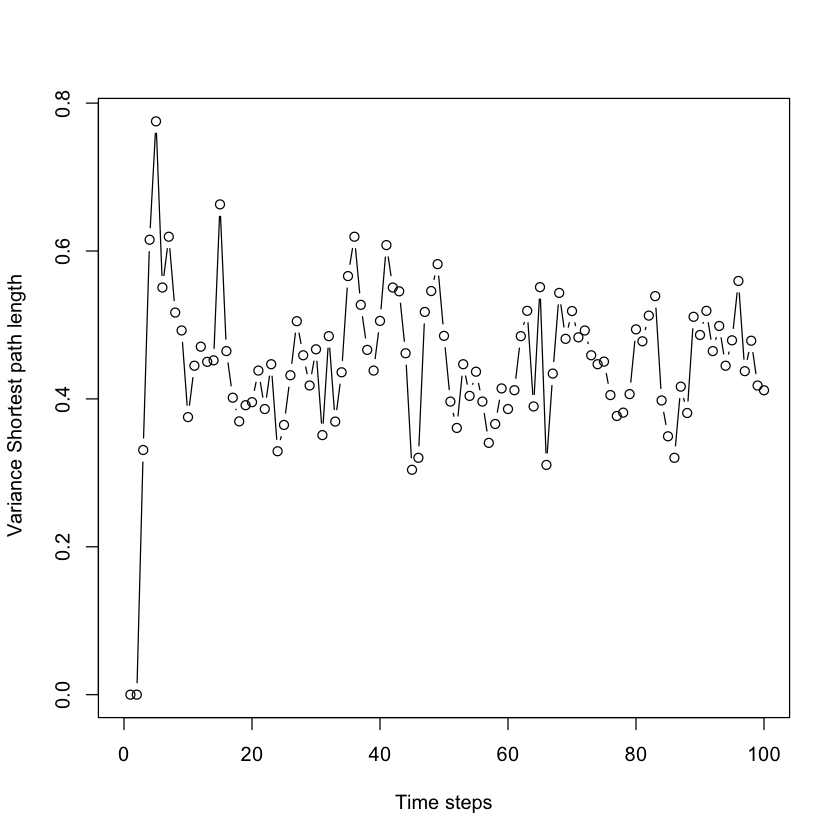

In [10]:
# Performing a 100 step random walk for 100 times on the erdos graph and plotting the mean and
# the variance of the shortest path
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(g_1000),100)
for(i in 1:iters){
    results = random_walk(g_1000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(g_1000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

(c) Measure the degree distribution of the nodes reached at the end of the random walk. How does it compare to the degree distribution of the graph?

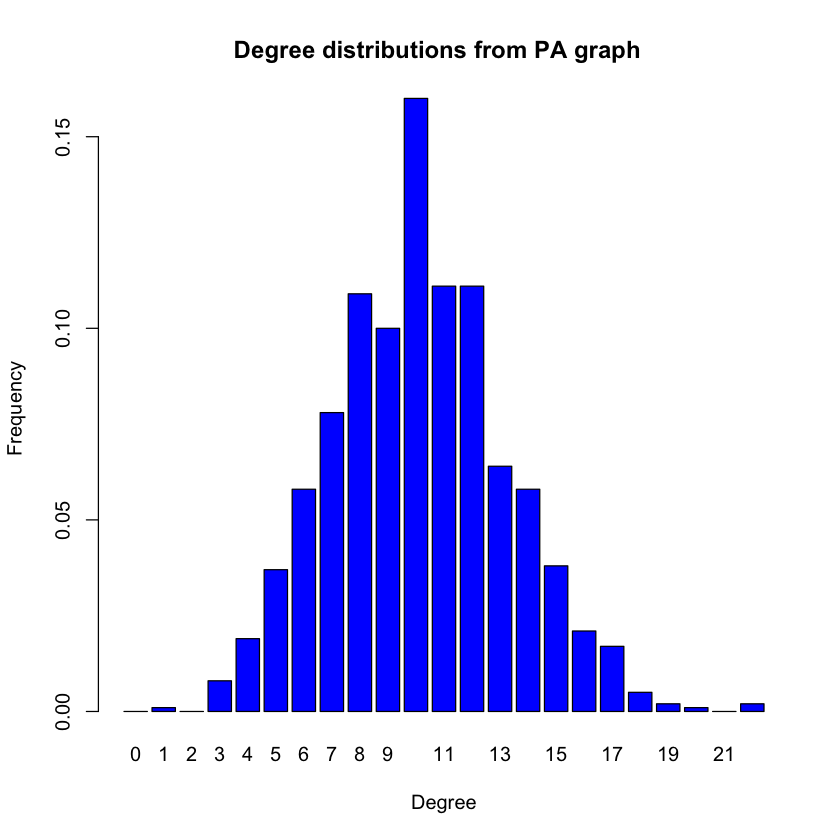

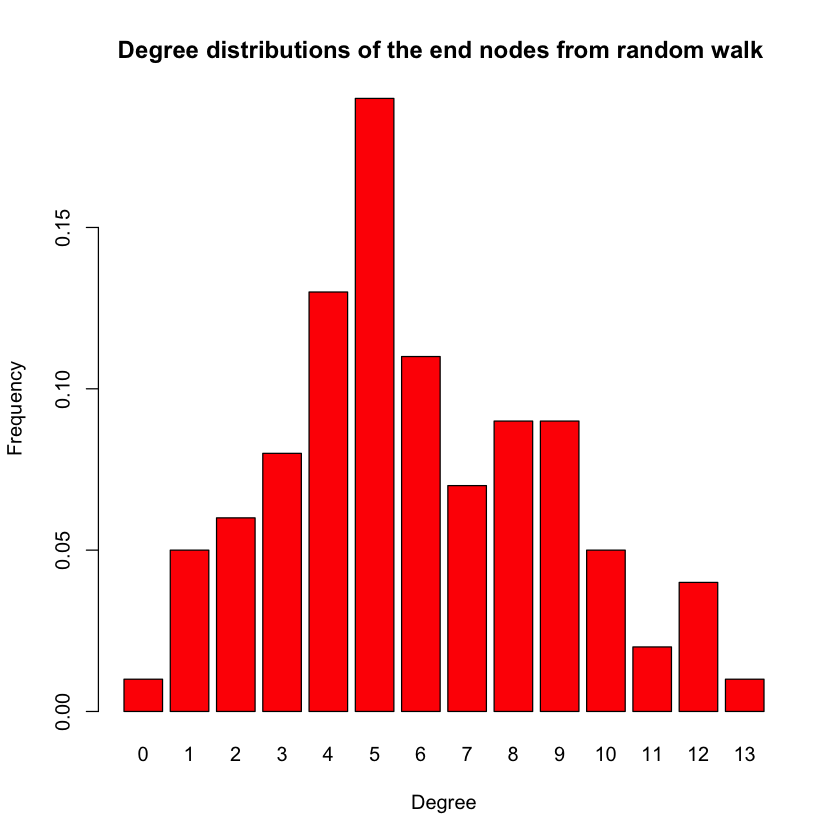

In [12]:
#  degree distribution of graph
d_dist = degree.distribution(g_1000)
xVals = c(0: (length(d_dist) - 1))
barplot(d_dist, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions from PA graph  " ,sep = " "), col="blue")


#  degree distribution from random walk over random nodes
freq = table(degree_list)/length(degree_list)
xVals = c(0: (length(freq) - 1))
barplot(freq, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions of the end nodes from random walk " ,sep = " "), col="red")

They look roughly comparable in shape. The peak for the overall degree distribution is greater than the peak for the random walk distribution. Both peaks are at different degrees. The right tail is also larger for the overall distribution compared to the random walk distribution.

(d) Repeat 1(b) for undirected random networks with 10000 nodes. Compare the results and explain qualitatively. Does the diameter of the network play a role?

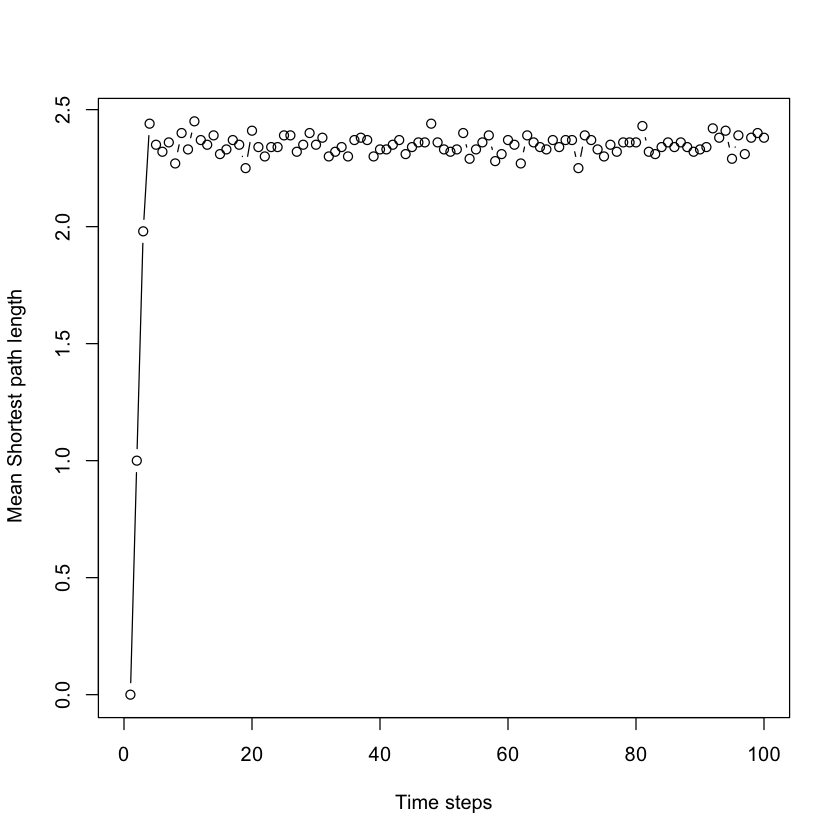

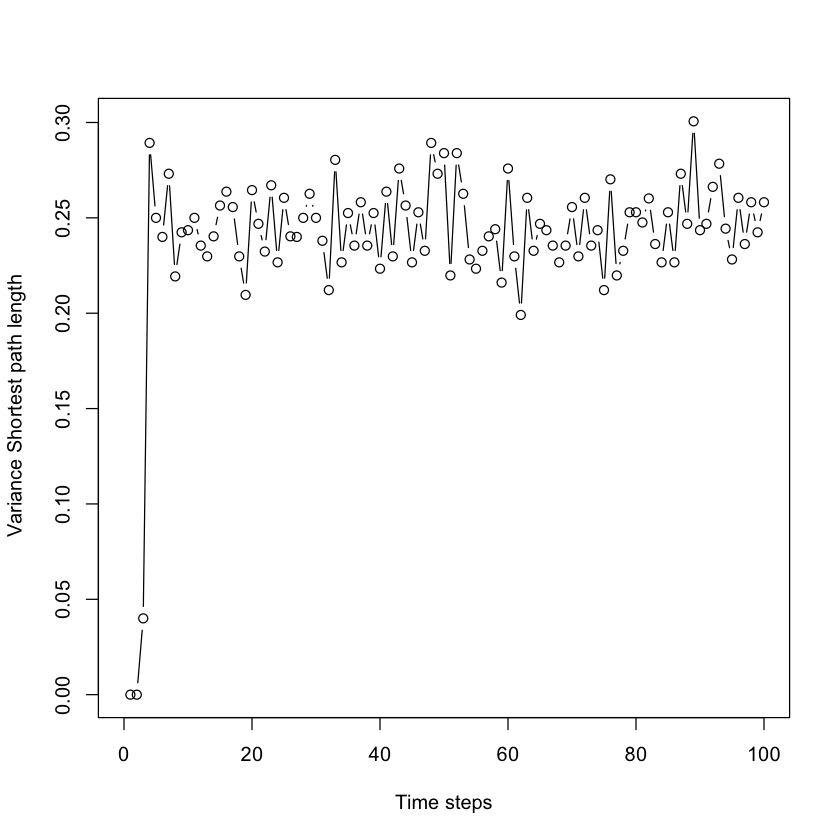

In [13]:
num_nodes = 10000
edge_prob = 0.01
g_10000 = sample_gnp(num_nodes, edge_prob, directed = FALSE)

degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(g_10000),100)
for(i in 1:iters){
    results = random_walk(g_10000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(g_10000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

In [14]:
print(paste("Diameter when n = 1000:", diameter(g_1000)))
print(paste("Diameter when n = 10000:", diameter(g_10000)))

[1] "Diameter when n = 1000: 6"
[1] "Diameter when n = 10000: 3"


Both the maximum mean shortest path and maximum variance shortest path are slightly lower for n=10000 at around 2.5 and 0.3 respectively than for n=1000 at 3.5 and 0.8 respectively. For n=1000, the mean looks to converge around 3.25 and the variance looks to converge around 0.45. For n=10000, the mean looks to converge around 2.4 and the variance looks to converge around 0.25. It appears that the diameter of the network does play a role since the network with the shorter diameter has a lower mean shortest path and lower variance.

## 2. Random walk on networks with fat-tailed degree distribution

(a) Generate an undirected preferential attachment network with 1000 nodes, where each new node attaches to m = 1 old nodes.

In [17]:
pa_1000 = sample_pa(n=1000, m=1, directed = FALSE)

(b) Let a random walker start from a randomly selected node. Measure and plot ⟨s(t)⟩ v.s. t and $σ^2(t)$ v.s. t.

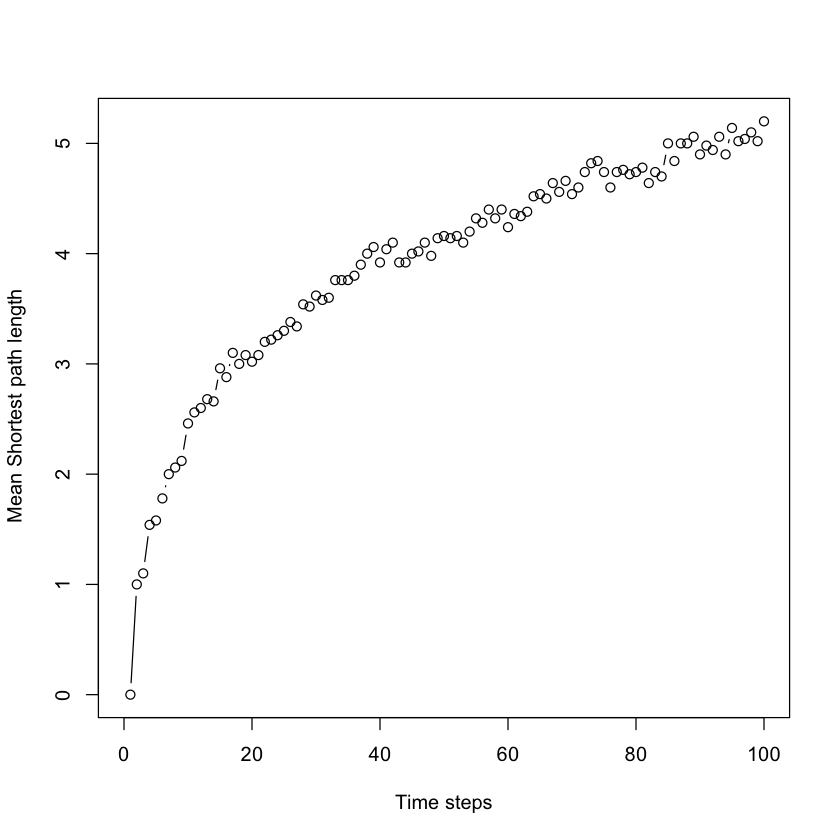

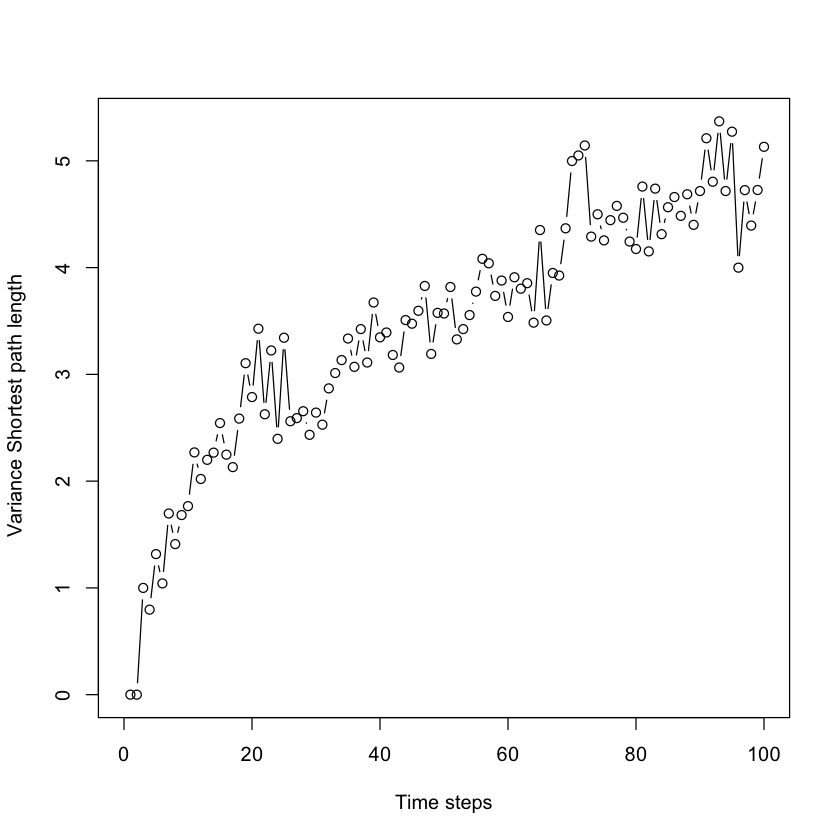

In [18]:
degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_1000),100)
for(i in 1:iters){
    results = random_walk(pa_1000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_1000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

(c) Measure the degree distribution of the nodes reached at the end of the random walk on this network. How does it compare with the degree distribution of the graph?

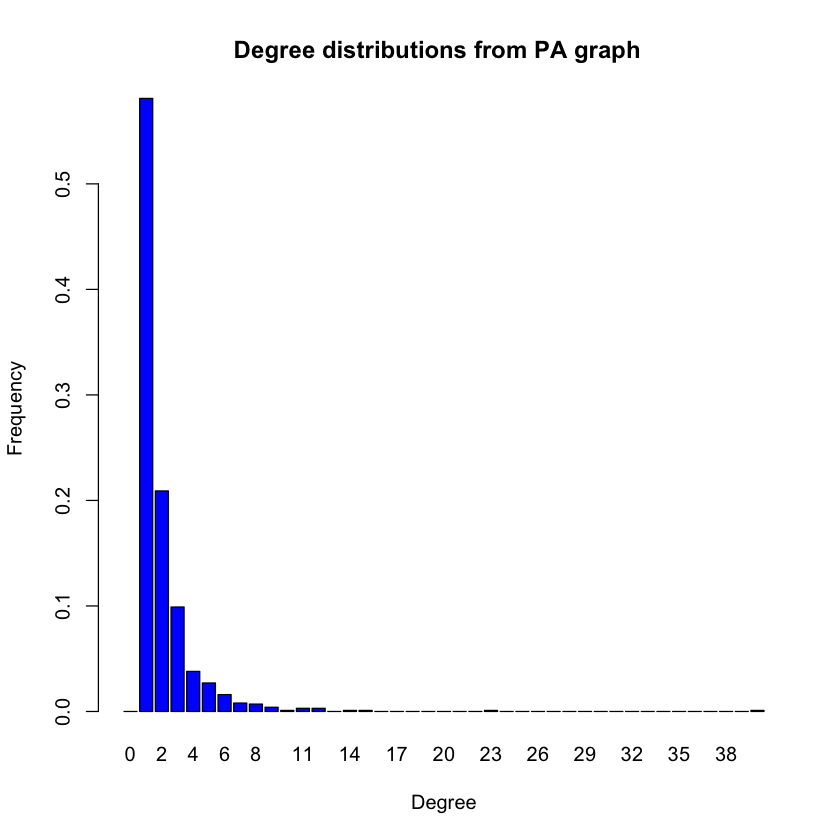

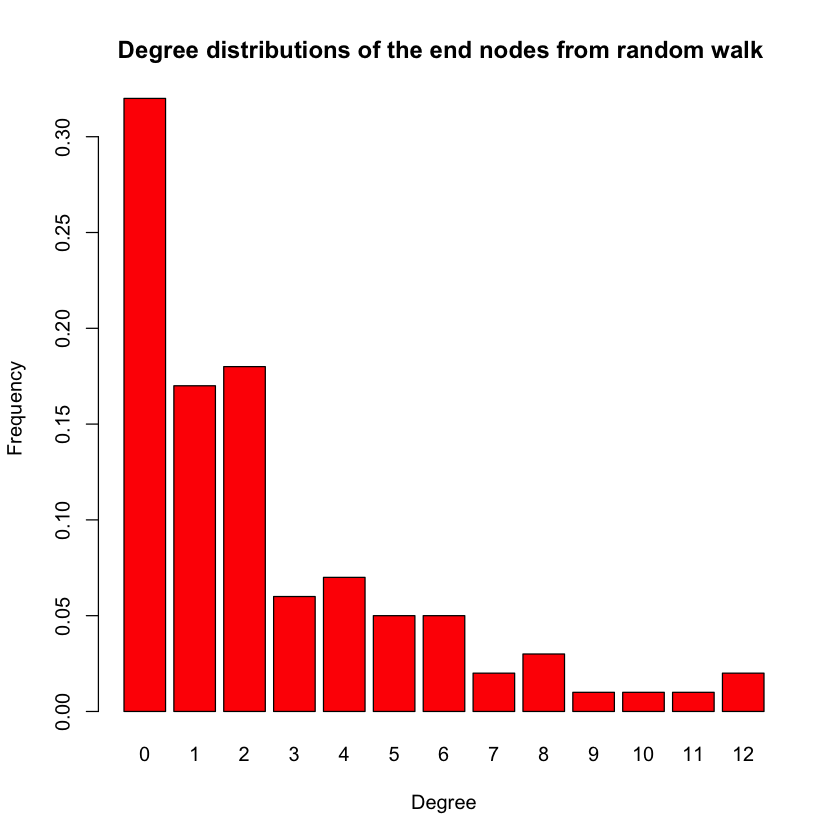

In [19]:
#  degree distribution of graph
d_dist = degree.distribution(pa_1000)
xVals = c(0: (length(d_dist) - 1))
barplot(d_dist, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions from PA graph  " ,sep = " "), col="blue")


#  degree distribution from random walk over random nodes
freq = table(degree_list)/length(degree_list)
xVals = c(0: (length(freq) - 1))
barplot(freq, names.arg=xVals, xlab="Degree", ylab="Frequency",
            main = paste("Degree distributions of the end nodes from random walk " ,sep = " "), col="red")

Both distributions are fat-tailed with degree 0 having the largest frequency. The overall distribution has a much larger frequency for this degree. There are fluctuations on the right-hand tail of the random walk distribution that are not present in the overall distribution.

(d) Repeat 2(b) for preferential attachment networks with 100 and 10000 nodes, and m = 1. Compare the results and explain qualitatively. Does the diameter of the network play a role?

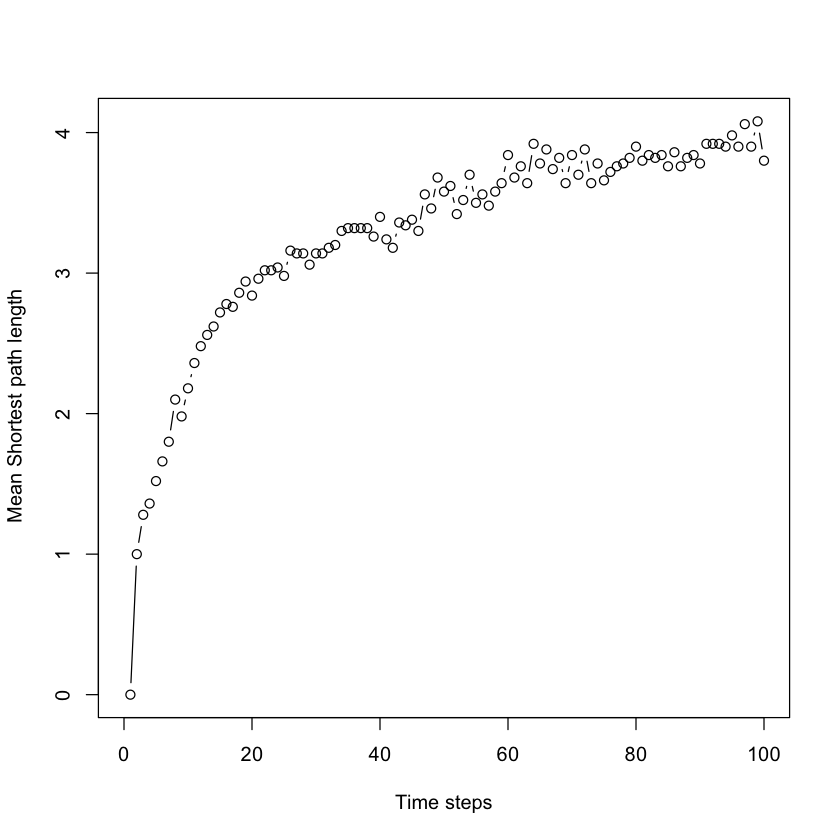

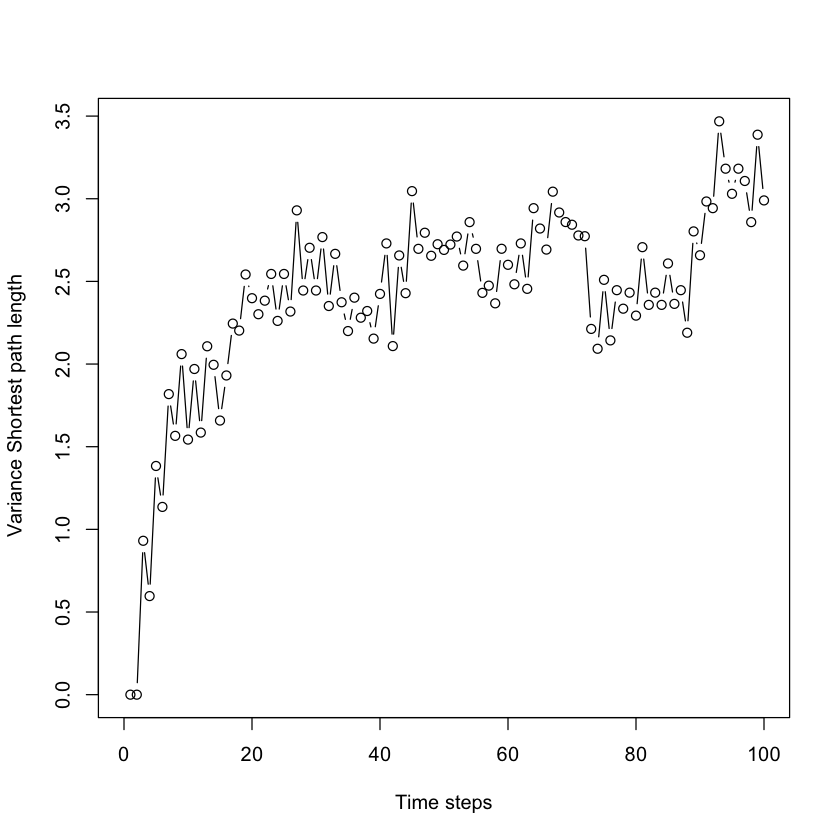

In [20]:
pa_100 = sample_pa(n=100, m=1, directed = FALSE)

degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_100),100)
for(i in 1:iters){
    results = random_walk(pa_100,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_100,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

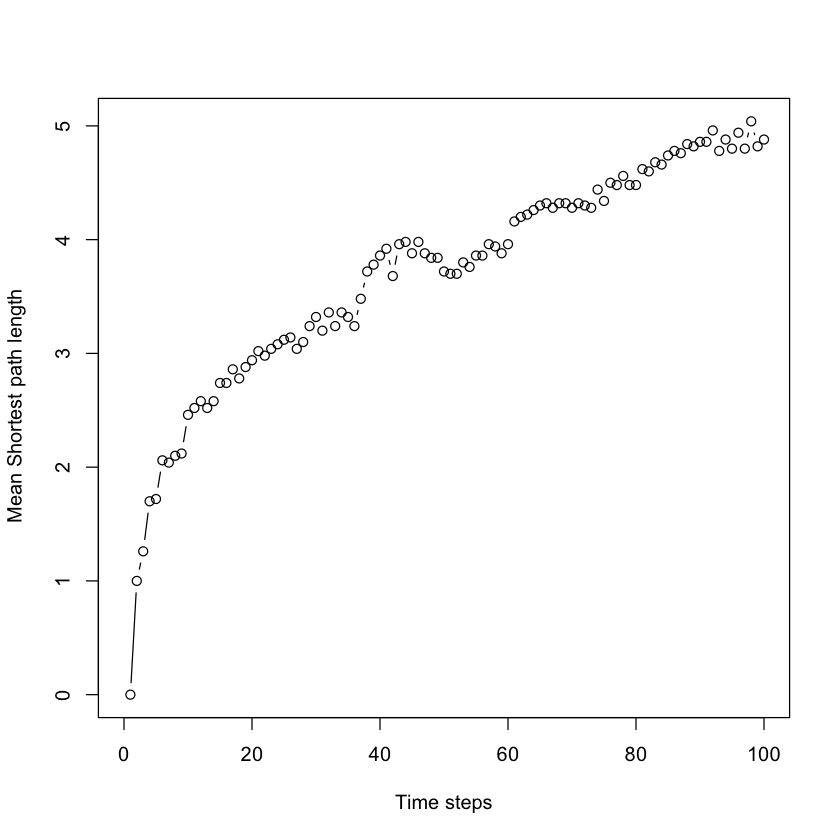

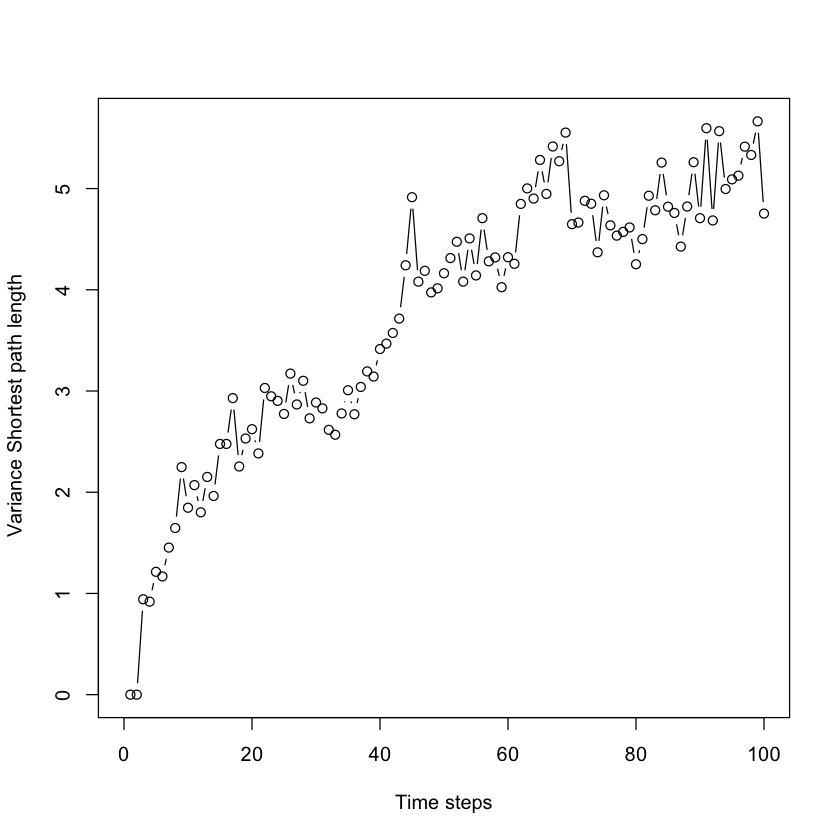

In [21]:
pa_10000 = sample_pa(n=10000, m=1, directed = FALSE)

degree_list = c(1:100)
iters = 100
distances = matrix(NA, nrow=iters, ncol=t)
start_nodes = sample(1:vcount(pa_10000),100)
for(i in 1:iters){
    results = random_walk(pa_10000,t,start_nodes[i])
    vertex_sequences = results[['distances']]
    end_node_degree = results[['degrees']][1]
    distances[i,] = shortest.paths(pa_10000,vertex_sequences,start_nodes[i])
    degree_list[i] = end_node_degree
}

plot(colMeans(distances),type="b", xlab='Time steps', ylab=' Mean Shortest path length', xlim=c(0,100))
plot(colVars(distances),type="b", xlab='Time steps', ylab=' Variance Shortest path length', xlim=c(0,100))

In [23]:
print(paste("Diameter when n = 100:", diameter(pa_100)))
print(paste("Diameter when n = 1000:", diameter(pa_1000)))
print(paste("Diameter when n = 10000:", diameter(pa_10000)))

[1] "Diameter when n = 100: 11"
[1] "Diameter when n = 1000: 21"
[1] "Diameter when n = 10000: 25"


For n=1000, both the mean and variance approach 5. For n=100, the mean approaches 4 while the variance is slightly more erratic as it approaches 3.5. For n=10000, the mean approaches 5 while the variance approaches 6. It appears that the diameter of the network does play a subtle role since for a smaller number of nodes, both the mean and variance are lower than those for larger number of nodes. However, there does seem to be a threshold where the maximum values converge to.

last third - Morgan